In [1]:
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from utils import load_data, post_processing, patientDataset, init_weights
from model.unet_model import UNet
from model.unet_2decoder import UNet_2Decoders
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from utils import load_data, post_processing, patientDataset, init_weights
import numpy as np
import torch
import scipy
import matplotlib.pyplot as plt

In [2]:
# define ivim function
def ivim(b, Dp, Dt, Fp):
    return Fp*np.exp(-b*Dp*1e-3) + (1-Fp)*np.exp(-b*Dt*1e-3)

In [3]:
# define racian bias
def ric_exp(nu, sigma):
    """
    t: SNR
    """
    t = nu / sigma
    res = sigma * (np.sqrt(np.pi/8)*
                ((2+t**2)*scipy.special.i0e(t**2/4)+
                t**2*scipy.special.i1e(t**2/4)))
    return res

In [4]:
b_values = np.linspace(0, 3000, 21)
b_values

array([   0.,  150.,  300.,  450.,  600.,  750.,  900., 1050., 1200.,
       1350., 1500., 1650., 1800., 1950., 2100., 2250., 2400., 2550.,
       2700., 2850., 3000.])

In [5]:
SNR_high,SNR_low=40,5
sigma_high,sigma_low=1/SNR_high,1/SNR_low

In [6]:
def get_dwi(b_values):
    # define parameter values in the three regions
    S0_region0, S0_region1, S0_region2 = 1500, 1400, 1600
    
    d1 = [np.random.uniform(2, 2.2), 2.2, np.random.uniform(2.2, 2.4)]
    d2 = [np.random.uniform(0.1, 0.3), 0.3, np.random.uniform(0.3, 0.5)]
    f = [np.random.uniform(0.5, 0.7), 0.7, np.random.uniform(0.7, 0.9)]
    d1.sort(), d2.sort(reverse=True), f.sort()
    #print(d1, d2, f)

    Dp_region0, Dp_region1, Dp_region2 = d1
    Dt_region0, Dt_region1, Dt_region2 = d2
    Fp_region0, Fp_region1, Fp_region2 = f
    # image size
    sx, sy, sb = 100, 100, len(b_values)
    # create image
    dwi_image = np.zeros((sx, sy, sb))
    Dp_truth = np.zeros((sx, sy))
    Dt_truth = np.zeros((sx, sy))
    Fp_truth = np.zeros((sx, sy))

    # fill image with simulated values
    for i in range(sx):
        for j in range(sy):
            if (40 < i < 60) and (40 < j < 60):
                # region 0
                dwi_image[i, j, :] = S0_region0*ivim(b_values, Dp_region0, Dt_region0, Fp_region0)
                Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region0, Dt_region0, Fp_region0
            elif (20 < i < 80) and (20 < j < 80):
                # region 1
                dwi_image[i, j, :] = S0_region1*ivim(b_values, Dp_region1, Dt_region1, Fp_region1)
                Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region1, Dt_region1, Fp_region1
            else:
                # region 2
                dwi_image[i, j, :] = S0_region2*ivim(b_values, Dp_region2, Dt_region2, Fp_region2)
                Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region2, Dt_region2, Fp_region2
    # add rician noise
    sigma = np.random.uniform(sigma_low, sigma_high, (sx, sy, 1))
    dwi_image = ric_exp(dwi_image, sigma)
    
    return dwi_image

In [7]:
def plot_dwi(dwi_image):
    # plot simulated diffusion weighted image
    fig, ax = plt.subplots(3, 7, figsize=(20,20))
    b_id = 0
    for i in range(3):
        for j in range(7):
            ax[i, j].imshow(dwi_image[:, :, b_id], cmap='gray', clim=(0, 1600))
            ax[i, j].set_title('b = ' + str(b_values[b_id]))
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            b_id += 1
    plt.subplots_adjust(hspace=-0.6)
    plt.show()

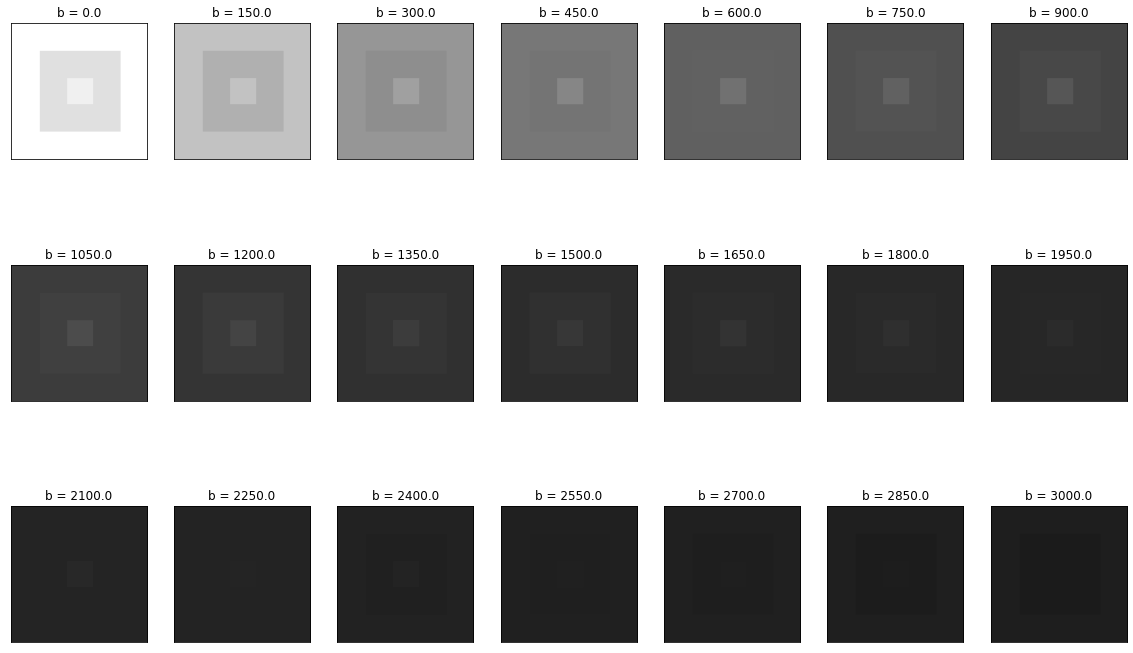

In [8]:
dwi_ = get_dwi(b_values)
plot_dwi(dwi_)

In [9]:
np.expand_dims(dwi_, axis=0).min()

171.58766355174586